In [93]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

### Задание 1
К алгоритму kNN, реализованному на уроке, реализуйте добавление весов соседей по любому из показанных на уроке принципов.

In [94]:
# загрузка датасета
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1, stratify=y)

X_train.shape, X_test.shape

((120, 2), (30, 2))

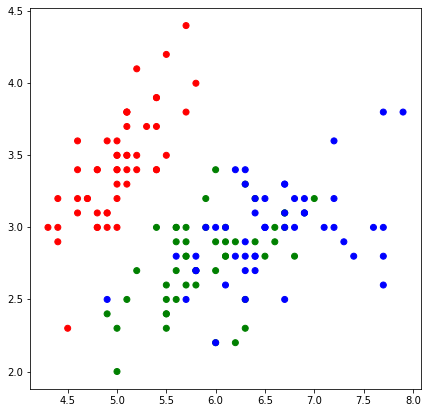

In [96]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

In [97]:
# евклидова метрика
def e_metrics(x1, x2):
    distance = np.sum(np.square(x1 - x2))
    return np.sqrt(distance)

In [98]:
{class_item: 0 for class_item in set(y_train)}

{0: 0, 1: 0, 2: 0}

**От номера соседа $i$ веса можно определять как:**

### - $w(i) = q^{i}$,   $q \in (0,1)$;

In [99]:
def weights_knn(i, d):
    q = 0.5
    w = q**i
    return w

In [100]:
def knn(x_train, y_train, x_test, k):
    answers = []
    for x in x_test:
        test_distances = []
        
        for i in range(len(x_train)):
            #расчет расстояния от классифицируемого объекта до объекта обучающей выборки:
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
            
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for i, d in enumerate (sorted(test_distances)[0:k]):
            w = weights(i, d)
            classes[d[1]] += w
        
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
 
        
    return answers       

In [101]:
# точность алгоритма
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [102]:
k = 5

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5: 0.700


In [103]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .1

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    print(np.c_[xx.ravel(), yy.ravel()].shape)

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)
    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

(2352, 2)


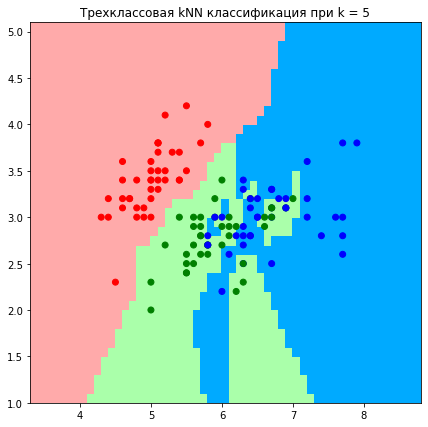

CPU times: user 2.81 s, sys: 32.1 ms, total: 2.84 s
Wall time: 2.86 s


In [104]:
%%time
get_graph(X_train, y_train, k)

### Задание 2
Напишите функцию по подсчёту метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и постройте график её зависимости от k (взять от 1 до 10) для выборки данных из этого урока.

In [105]:
# генерация датасета
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=800, centers = 3, random_state=1)

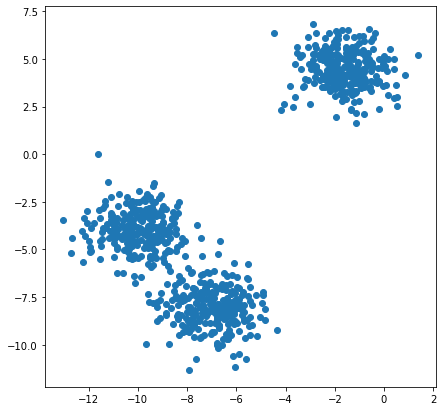

In [106]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [107]:
def kmeans(data, k, max_iterations, min_distance):    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # Создадим словарь для классификации
        classes = {i: [] for i in range(k)}
        
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесём объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения с новыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

In [108]:
def kmeans_predict(centroids, data):    
    # инициализируем центроиды как первые k элементов датасета
    classes = [i for i in range(len(centroids))]
    label = []
    # классифицируем объекты по центроидам
    for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            #print(classification)
            label.append(classification)
    return label

In [109]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b','m','y']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
    plt.grid(True)        
    plt.show()

In [110]:
# определим максимальное количество итераций
max_iterations = 10

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 3

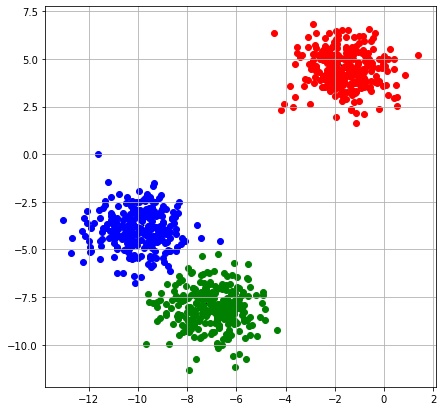

In [111]:
centroids, clusters = kmeans(X[10:,:], k, max_iterations, min_distance)

visualize(centroids, clusters)

- По аналогии с квадратичным внутрикластерным расстоянием - среднее квадратичное внутрикластерное расстояние.

    $$\sum_{k=1}^{K}\frac{1}{|k|}\sum_{i=1}^{l}[a(x_{i})=k]\rho^{2}(x_{i}, c_{k}),$$

In [112]:
def mean_square_in_cluster(clusters, centroids):
    m = 0
    for cluster, data in clusters.items():
        dist = 0
        for x in data:
            dist += e_metrics(centroids[cluster], x) ** 2
        dist /= len(data)
        m += dist
    return m

График её зависимости от k (взять от 1 до 10)

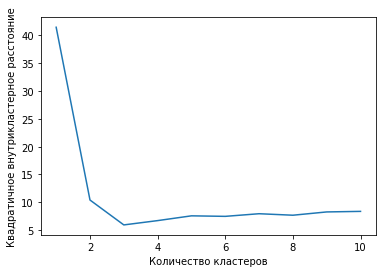

In [113]:
n_clusters = range(1, 11)
errors = []

for k in n_clusters:
    centroids, clusters = kmeans(X[10:,:], k, max_iterations, min_distance)
    errors.append(mean_square_in_cluster(clusters, centroids))

plt.plot(n_clusters, errors)
plt.xlabel('Количество кластеров')
plt.ylabel('Квадратичное внутрикластерное расстояние')
plt.show()

По графику можно сделать вывод, что оптимальное количество кластеров равно 3